In [1]:
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm

from astropy.io import fits
from astropy.io.fits.hdu.image import ImageHDU, PrimaryHDU
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
from matplotlib.colors import LogNorm

from astropy.visualization import ImageNormalize, AsinhStretch, PercentileInterval

import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
data = pd.read_csv('lens/result.csv') # Complete modeling results are in 'modeling_lens_mass.csv'
data = data.drop(['Unnamed: 0'], axis=1)
print(data.columns)
data.head()

Index(['id_str', 'einstein_radius_max_lh', 'einstein_radius_median_pdf',
       'einstein_radius_lower_3_sigma', 'einstein_radius_upper_3_sigma',
       'vis_total_lens_flux', 'vis_total_lensed_source_flux',
       'vis_total_source_flux', 'vis_magnification',
       'vis_max_lensed_source_signal_to_noise_ratio'],
      dtype='object')


,id_str,einstein_radius_max_lh,einstein_radius_median_pdf,einstein_radius_lower_3_sigma,einstein_radius_upper_3_sigma,vis_total_lens_flux,vis_total_lensed_source_flux,vis_total_source_flux,vis_magnification,vis_max_lensed_source_signal_to_noise_ratio
0,102018665_NEG570040238507752998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102018665_NEG576731213511114485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,102018666_NEG579859279508531437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,102018667_NEG587746535508057234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,102018668_NEG595646727509469177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Working with only one candidate file, as an example:
id_str = '102018665_NEG570040238507752998'
filename = 'lens/' + id_str + '/' + id_str + '.fits'

# get data from fits file
hdu_list = fits.open(filename)
hdu_list.info() #Shows the Name (or header) of each file component

# See output of .info():
# Flux: actual astronomical images, RMS: Root Mean Square noise map (uncertainty per pixel), PSF: star 
# Bands: VIS, NIR_Y, NIR_J, NIR_H. Accesing the image for each band:
image_vis = hdu_list[1].data.astype(np.float32)
image_NIR_Y = hdu_list[4].data.astype(np.float32)
image_NIR_J = hdu_list[7].data.astype(np.float32)
image_NIR_H = hdu_list[10].data.astype(np.float32)

hdu_list.close()

Filename: lens/102018665_NEG570040238507752998/102018665_NEG570040238507752998.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  VIS_FLUX      1 ImageHDU        62   (300, 300)   float32   
  2  VIS_PSF       1 ImageHDU         9   (21, 21)   float32   
  3  VIS_RMS       1 ImageHDU         8   (300, 300)   float32   
  4  NIR_Y_FLUX    1 ImageHDU        62   (300, 300)   float32   
  5  NIR_Y_PSF     1 ImageHDU         9   (33, 33)   float32   
  6  NIR_Y_RMS     1 ImageHDU         8   (300, 300)   float32   
  7  NIR_J_FLUX    1 ImageHDU        62   (300, 300)   float32   
  8  NIR_J_PSF     1 ImageHDU         9   (33, 33)   float32   
  9  NIR_J_RMS     1 ImageHDU         8   (300, 300)   float32   
 10  NIR_H_FLUX    1 ImageHDU        62   (300, 300)   float32   
 11  NIR_H_PSF     1 ImageHDU         9   (33, 33)   float32   
 12  NIR_H_RMS     1 ImageHDU         8   (300, 300)   float32   


In [4]:
#Saving all flux images (actual astronomical images) into one numpy array object
pix = 300 # Number of pixels
images = np.zeros((1, 4, pix, pix))

for i in tqdm(range(len(data)), desc="Loading FITS", unit="file"):
    id_str = data['id_str'].iloc[i]
    filename = f'lens/{id_str}/{id_str}.fits'
    hdu_list = fits.open(filename)

    image = np.empty((4, pix, pix), dtype=np.float32)
    image[0] = hdu_list[1].data.astype(np.float32) #VIS
    image[1] = hdu_list[4].data.astype(np.float32) #NIR_Y
    image[2] = hdu_list[7].data.astype(np.float32) #NIR_J
    image[3] = hdu_list[10].data.astype(np.float32) #NIR_H

    images = np.append(images, [image], axis=0)
    hdu_list.close()
    
images = np.delete(images, 0, axis=0)

Loading FITS:   0%|          | 0/335 [00:00<?, ?file/s]

In [5]:
# All candidates images as one numpy array:
images.shape #Number of candidates, photometric bands, pixels, pixels

(335, 4, 300, 300)

In [6]:
# Different functions to plot the astronomical images

def plot_all_bands(image):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes = axes.flatten()
    bands = ['VIS', 'NIR_Y', 'NIR_J', 'NIR_H']

    for i in range(len(bands)):
        axes[i].set_title(bands[i])
        axes[i].imshow(image[i], aspect='equal')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()
    
def plot_all_bands_log(image, pmin=1, pmax=99.9, cmap="gray"):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    bands = ['VIS', 'NIR_Y', 'NIR_J', 'NIR_H']

    for i, ax in enumerate(axes):
        im = image[i]
        finite = im[np.isfinite(im)]
        vmin, vmax = np.percentile(finite, [pmin, pmax])

        # LogNorm requires vmin > 0, so shift if needed
        if vmin <= 0:
            shift = -vmin + 1e-6
            im2 = im + shift
            vmin, vmax = vmin + shift, vmax + shift
        else:
            im2 = im

        ax.imshow(im2, cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax), origin="lower")
        ax.set_title(bands[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()
    
    
def plot_all_bands_asinh(image, pmax=99.8, cmap="gray"):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    bands = ['VIS', 'NIR_Y', 'NIR_J', 'NIR_H']

    interval = PercentileInterval(pmax)  # clips low/high robustly
    stretch = AsinhStretch(a=0.03)       # tweak a: smaller -> more contrast in faint stuff

    for i, ax in enumerate(axes):
        im = image[i]
        norm = ImageNormalize(im, interval=interval, stretch=stretch)
        ax.imshow(im, cmap=cmap, norm=norm, origin="lower")
        ax.set_title(bands[i])
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    plt.close()
    

def plot_all_bands_asinh_zoom(image, pmax=99.8, cmap="gray"):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    bands = ['VIS', 'NIR_Y', 'NIR_J', 'NIR_H']

    interval = PercentileInterval(pmax)  # clips low/high robustly
    stretch = AsinhStretch(a=0.03)       # tweak a: smaller -> more contrast in faint stuff

    for i, ax in enumerate(axes):
        im = image[i]
        norm = ImageNormalize(im, interval=interval, stretch=stretch)
        ax.imshow(im, cmap=cmap, norm=norm, origin="lower")
        ax.set_title(bands[i])
        ax.axis("off")
        ax.set_xlim(120, 180)
        ax.set_ylim(120, 180)

    plt.tight_layout()
    plt.show()
    plt.close()

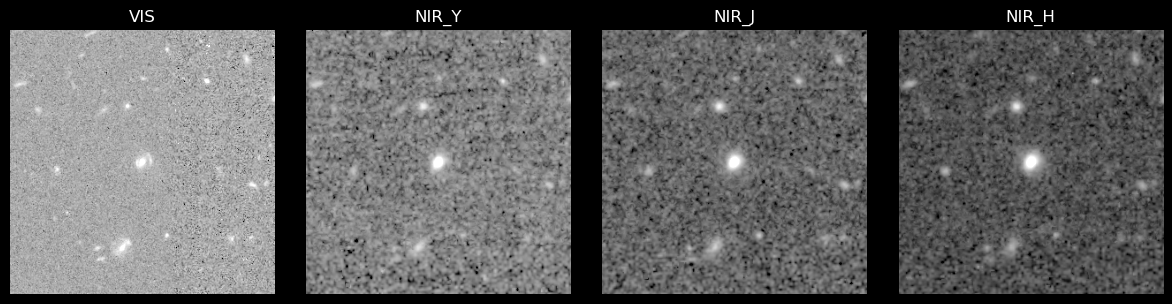

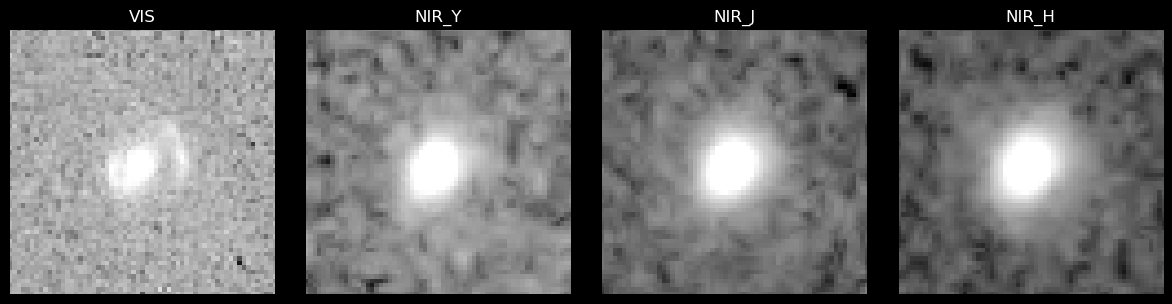

In [7]:
#Example of images of one candidate
#plot_all_bands(images[0])
#plot_all_bands_log(images[0])
plot_all_bands_asinh(images[0]) 
plot_all_bands_asinh_zoom(images[0]) #Zoomed in figure

Candidate ID:  102018665_NEG570040238507752998


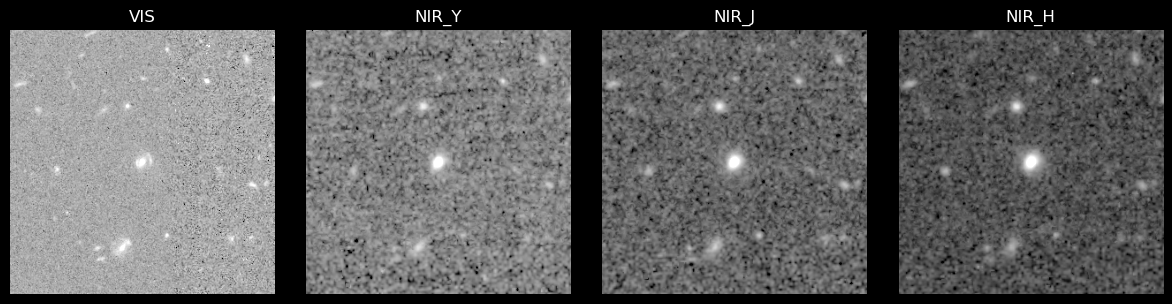

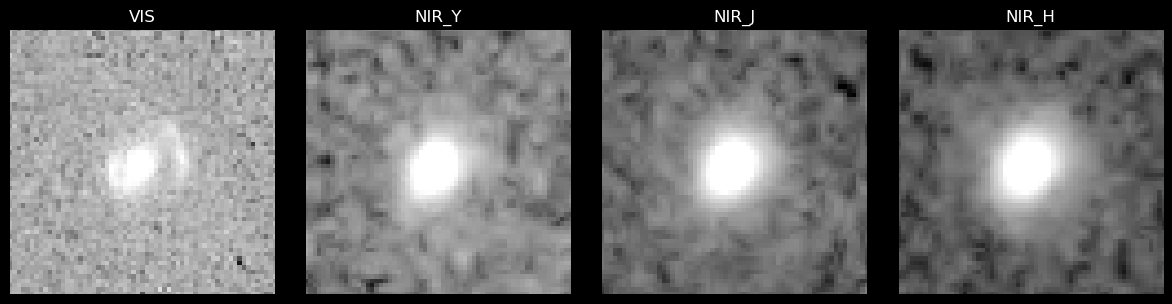

Candidate ID:  102018665_NEG576731213511114485


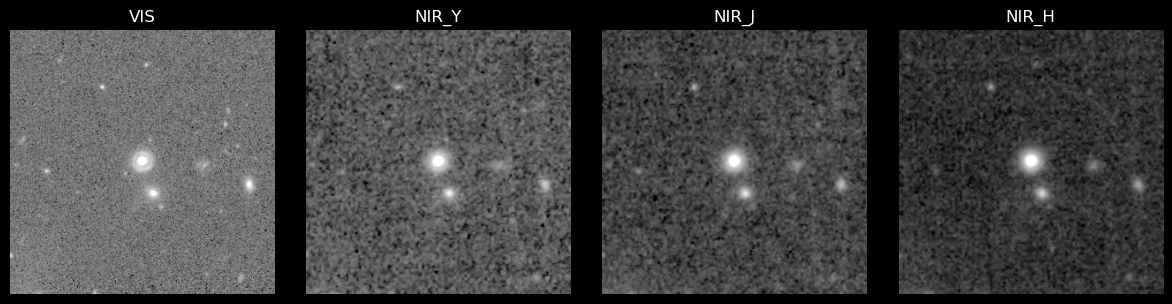

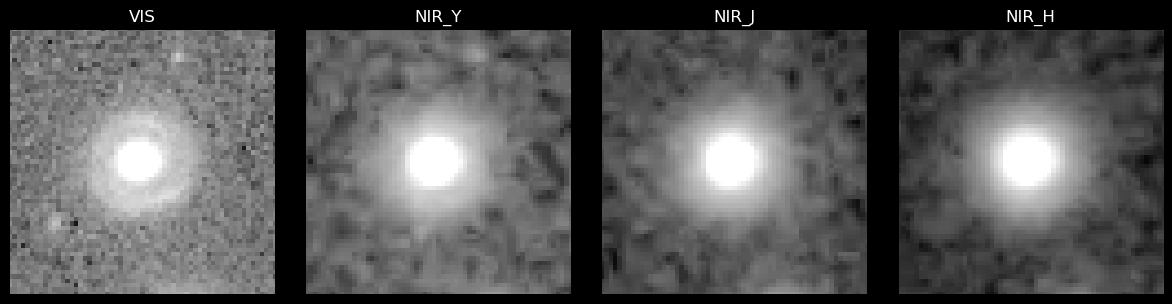

Candidate ID:  102018666_NEG579859279508531437


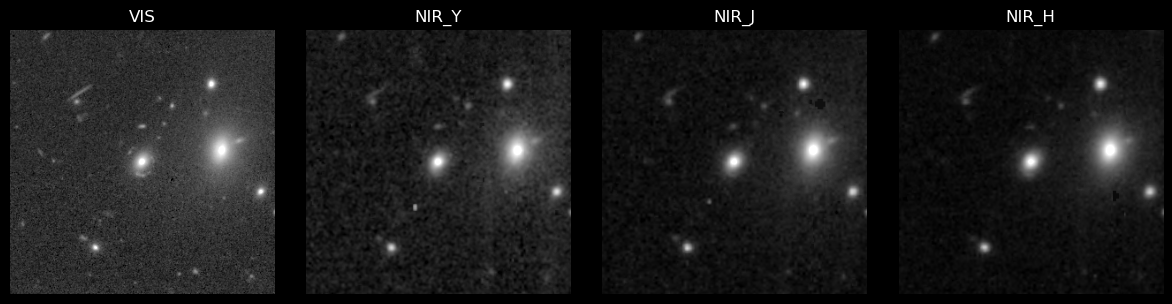

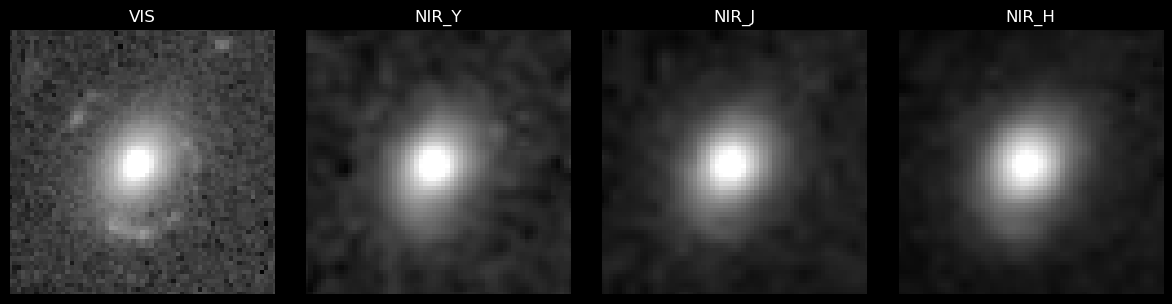

Candidate ID:  102018667_NEG587746535508057234


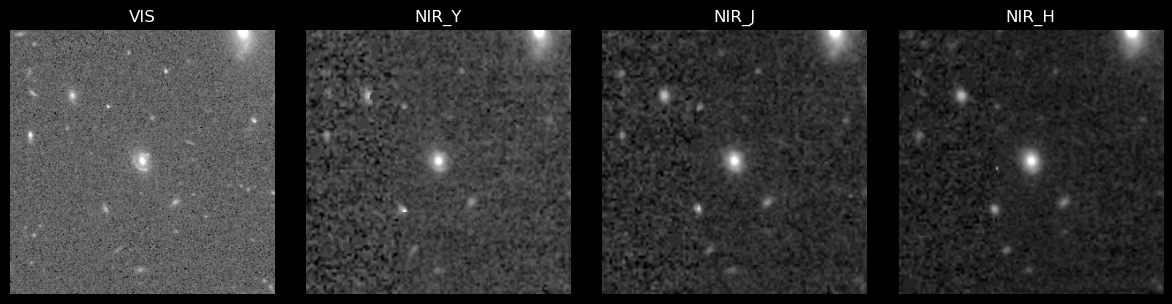

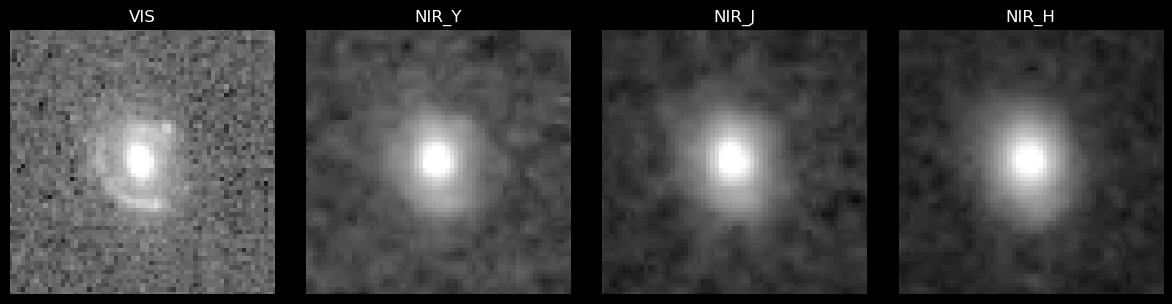

In [8]:
# Images of first four candidates
for i in(range(4)):
    print('Candidate ID: ', data['id_str'].iloc[i])
    plot_all_bands_asinh(images[i])
    plot_all_bands_asinh_zoom(images[i])